<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Posterior for Beta-binomial distribution

We compare various approximations to the exact 1d distribution.

In [3]:
# https://github.com/probml/pyprobml/blob/master/scripts/beta_binom_approx_post_pymc3.py

# 1d approixmation to beta binomial model
# https://github.com/aloctavodia/BAP


# import superimport

import pymc3 as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import math

# import pyprobml_utils as pml

# data = np.repeat([0, 1], (10, 3))
data = np.repeat([0, 1], (10, 1))
h = data.sum()
t = len(data) - h

## Exact

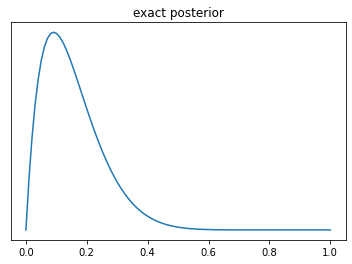

In [4]:
plt.figure()
x = np.linspace(0, 1, 100)
xs = x  # grid
dx_exact = xs[1] - xs[0]
post_exact = stats.beta.pdf(xs, h + 1, t + 1)
post_exact = post_exact / np.sum(post_exact)
plt.plot(xs, post_exact)
plt.yticks([])
plt.title("exact posterior")
plt.savefig("bb_exact.pdf")

## Grid

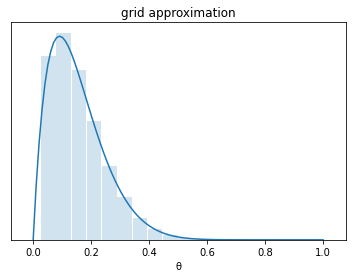

In [5]:
# Grid
def posterior_grid(heads, tails, grid_points=100):
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1 / grid_points, grid_points)  # uniform prior
    likelihood = stats.binom.pmf(heads, heads + tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    # posterior = posterior * grid_points
    return grid, posterior


n = 20
grid, posterior = posterior_grid(h, t, n)
dx_grid = grid[1] - grid[0]
sf = dx_grid / dx_exact  # Jacobian scale factor
plt.figure()
# plt.stem(grid, posterior, use_line_collection=True)
plt.bar(grid, posterior, width=1 / n, alpha=0.2)
plt.plot(xs, post_exact * sf)
plt.title("grid approximation")
plt.yticks([])
plt.xlabel("θ")
plt.savefig("bb_grid.pdf")

## Laplace


[array(0.09090909), array([0.08667842])]


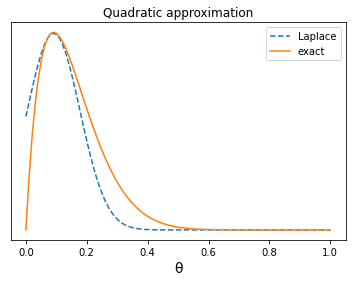

In [6]:
# Laplace
with pm.Model() as normal_aproximation:
    theta = pm.Beta("theta", 1.0, 1.0)
    y = pm.Binomial("y", n=1, p=theta, observed=data)  # Bernoulli
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[theta])) ** 0.5)[0]
    mu = mean_q["theta"]

print([mu, std_q])

plt.figure()
plt.plot(xs, stats.norm.pdf(xs, mu, std_q), "--", label="Laplace")
post_exact = stats.beta.pdf(xs, h + 1, t + 1)
plt.plot(xs, post_exact, label="exact")
plt.title("Quadratic approximation")
plt.xlabel("θ", fontsize=14)
plt.yticks([])
plt.legend()
plt.savefig("bb_laplace.pdf");

## ADVI

Finished [100%]: Average Loss = 4.9281


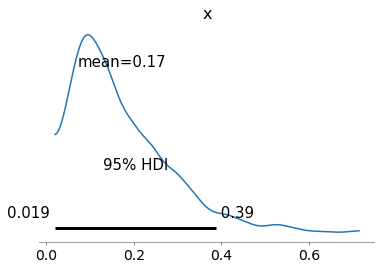

In [9]:
# ADVI
with pm.Model() as mf_model:
    theta = pm.Beta("theta", 1.0, 1.0)
    y = pm.Binomial("y", n=1, p=theta, observed=data)  # Bernoulli
    mean_field = pm.fit(method="advi")
    trace_mf = mean_field.sample(1000)
thetas = trace_mf["theta"]
axes = az.plot_posterior(thetas, hdi_prob=0.95)
plt.savefig("bb_mf.pdf")

plt.show()

Finished [100%]: Average Loss = 4.9367


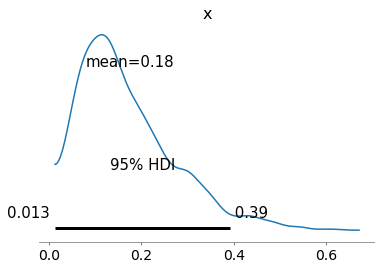

In [10]:
# track mean and std
with pm.Model() as mf_model:
    theta = pm.Beta("theta", 1.0, 1.0)
    y = pm.Binomial("y", n=1, p=theta, observed=data)  # Bernoulli
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval, std=advi.approx.std.eval  # callable that returns mean  # callable that returns std
    )
    approx = advi.fit(callbacks=[tracker])

trace_approx = approx.sample(1000)
thetas = trace_approx["theta"]

axes = az.plot_posterior(thetas, hdi_prob=0.95)
plt.savefig("bb_mf_kde_az.pdf")

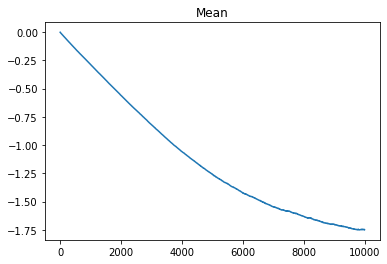

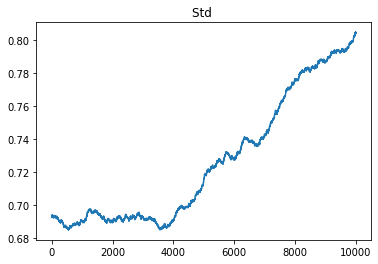

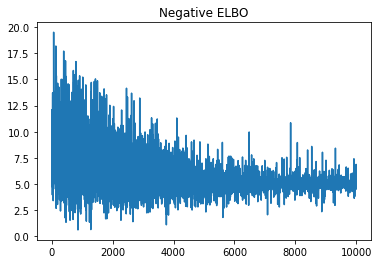

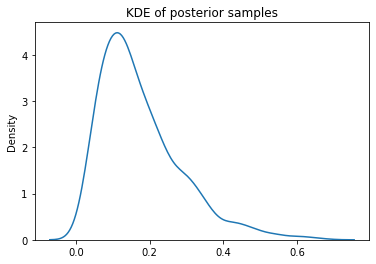

In [12]:
plt.figure()
plt.plot(tracker["mean"])
plt.title("Mean")
plt.savefig("bb_mf_mean.pdf")

plt.figure()
plt.plot(tracker["std"])
plt.title("Std ")
plt.savefig("bb_mf_std.pdf")

plt.figure()
plt.plot(advi.hist)
plt.title("Negative ELBO")
plt.savefig("bb_mf_elbo.pdf")

plt.figure()
sns.kdeplot(thetas)
plt.title("KDE of posterior samples")
plt.savefig("bb_mf_kde.pdf")

plt.show()

## HMC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


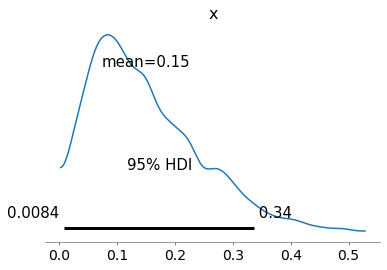

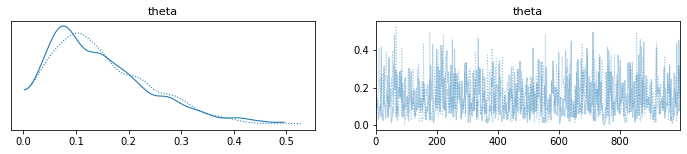

In [14]:
# HMC
with pm.Model() as hmc_model:
    theta = pm.Beta("theta", 1.0, 1.0)
    y = pm.Binomial("y", n=1, p=theta, observed=data)  # Bernoulli
    trace = pm.sample(1000, random_seed=42, cores=1, chains=2)
thetas = trace["theta"]
axes = az.plot_posterior(thetas, hdi_prob=0.95)
plt.savefig("bb_hmc.pdf")

az.plot_trace(trace)
plt.savefig("bb_hmc_trace.pdf", dpi=300)